In [26]:
import torch,os
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

from torchvision.io import read_image
from pathlib import Path
from PIL import Image

from xml.etree import ElementTree as ET
from torch.utils.data import Dataset,DataLoader,random_split

import torchvision.transforms.functional as F
import numpy as np

import cv2

In [21]:
class CustomDataset(Dataset):
    def __init__(self,root_dir, xml_file,color_file, transform=None ) -> None:
        self.root_dir = root_dir
        self.color_mapping = self.load_color_mapping(color_file)
        self.data = self.parse_xml(xml_file)
        self.transform = transform

    def load_color_mapping(self,color_file):
        color_mapping = {}
        with open(color_file,'r') as file:
            for line in file:
                color_id, color_name = line.strip().split(' ',1)
                color_mapping[int(color_id)-1] = color_name
        return color_mapping

    def parse_xml(self, xml_file):
        data = []
        with open(xml_file,'r') as file:
            tree = ET.fromstring(file.read())
            tree = ET.ElementTree(tree)
            root = tree.getroot()
            for item in root.findall('.//Item'):
                image_name = item.get('imageName')
                color_id = int(item.get('colorID'))
                data.append((image_name,color_id))
        return data

    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        img_name, color_id = self.data[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, color_id-1, img_name




In [27]:
FOLDER_DATASET = "/mnt/linux/stallionSpace/itu/semester3/thesis1/datasets/VeRi"
FOLDER_TARGET = "/mnt/linux/stallionSpace/itu/semester3/thesis1/datasets/VeRi_mask"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


test_dataset = CustomDataset(FOLDER_DATASET+"/image_test",FOLDER_DATASET+"/test_label.xml",FOLDER_DATASET+"/list_color.txt")

In [9]:
weights = FCN_ResNet50_Weights.DEFAULT
transforms = weights.transforms(resize_size=None)

model = fcn_resnet50(weights=weights, progress=False)
model = model.eval()

sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}

In [28]:
sem_class_to_idx

{'__background__': 0,
 'aeroplane': 1,
 'bicycle': 2,
 'bird': 3,
 'boat': 4,
 'bottle': 5,
 'bus': 6,
 'car': 7,
 'cat': 8,
 'chair': 9,
 'cow': 10,
 'diningtable': 11,
 'dog': 12,
 'horse': 13,
 'motorbike': 14,
 'person': 15,
 'pottedplant': 16,
 'sheep': 17,
 'sofa': 18,
 'train': 19,
 'tvmonitor': 20}

In [25]:
test_dataset[0][2]

'0002_c002_00030600_0.jpg'

In [22]:
for car_idx in range(len(test_dataset)):
    car_list = [test_dataset[car_idx][0]]
    batch = torch.stack([transforms(d) for d in car_list])
    output = model(batch)['out']

    normalized_masks = torch.nn.functional.softmax(output, dim=1)

    mask = normalized_masks[0,sem_class_to_idx['car']]  
    mask_img = mask.detach()
    mask_img = F.to_pil_image(mask_img)
    break


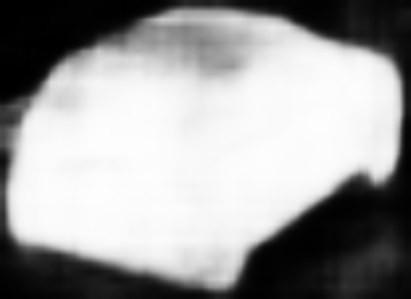

In [15]:
mask_img = mask.detach()
mask_img = F.to_pil_image(mask_img)
mask_img

In [17]:
mask_img_np = np.asarray(mask_img)

In [19]:
temp_np = np.zeros_like(mask_img_np)
temp_np[mask_img_np > 100] = 255

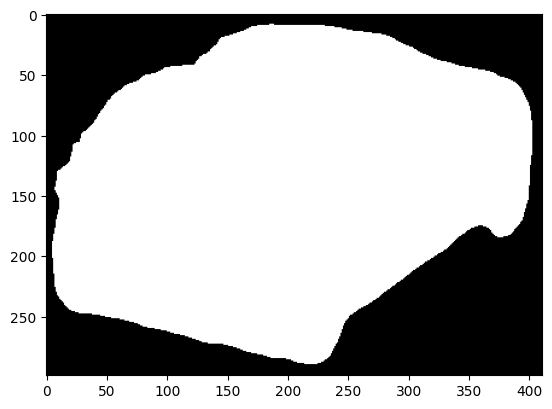

In [20]:
import matplotlib.pyplot as plt
plt.imshow(temp_np,'gray')